In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,Callback
from tensorflow.keras.layers import RandomSaturation, RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import os
import random

In [2]:
# to have reproducable results
tf.random.set_seed(58)
np.random.seed(58)
random.seed(58)

# importing the malaria dataset from tensorflow

data = tfds.load('malaria',split=['train[:80%]','train[80%:85%]','train[85%:]'],shuffle_files=True,)
train_set = data[0]
cv_set = data[1]
test_set = data[2]

# preprocess the data by resizing all the images to standard 180x180 pxls 
# and normalizing the 256 bit format through dividing by 255 (max value)
def image_resize(data):
    return tf.image.resize(data['image'],size=(180,180))/255 , data['label']

# appliying preprocessing transformations 
train_set = train_set.map(image_resize)
train_set = train_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

cv_set = cv_set.map(image_resize)
cv_set = cv_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

test_set = test_set.map(image_resize)
test_set = test_set.batch(batch_size=64).cache().prefetch(tf.data.AUTOTUNE)

2025-09-28 01:02:17.606529: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-09-28 01:02:17.606566: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-28 01:02:17.606569: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-09-28 01:02:17.606583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-28 01:02:17.606595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# getting to know the count of different classes and sample sets
total_uninfected = 0
for i,split in zip(range(3),['train','cv','test']):
    labels = data[i].map(lambda x: x['label'])
    # as 1 = uninfected, total number of uninfected samples can be obtained by taking sum of all the sample's label
                                                # initializing 0 to perform running total
    uninfected_count = labels.reduce(tf.constant(0,dtype=tf.int32),
                                     lambda x, y: x + tf.cast(y, tf.int32)) # x=running total y=current label
    total_uninfected += uninfected_count

    print(f'\nTotal number of samples in {split} set : {len(data[i])}')
    print(f'Total number of Uninfected samples in {split} set : {uninfected_count}')
    print(f'Total number of Parasitised samples in {split} set : {len(data[i])-uninfected_count}')

print(f'\nTotal number of Uninfected samples in the dataset : {total_uninfected}')
print(f'Total number of Parasitised samples in the dataset : {len(data[0])+len(data[1])+len(data[2])-total_uninfected}')

2025-09-28 01:02:19.668584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Total number of samples in train set : 22046
Total number of Uninfected samples in train set : 11047
Total number of Parasitised samples in train set : 10999

Total number of samples in cv set : 1378
Total number of Uninfected samples in cv set : 684
Total number of Parasitised samples in cv set : 694

Total number of samples in test set : 4134
Total number of Uninfected samples in test set : 2048
Total number of Parasitised samples in test set : 2086

Total number of Uninfected samples in the dataset : 13779
Total number of Parasitised samples in the dataset : 13779


2025-09-28 13:23:03.976667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


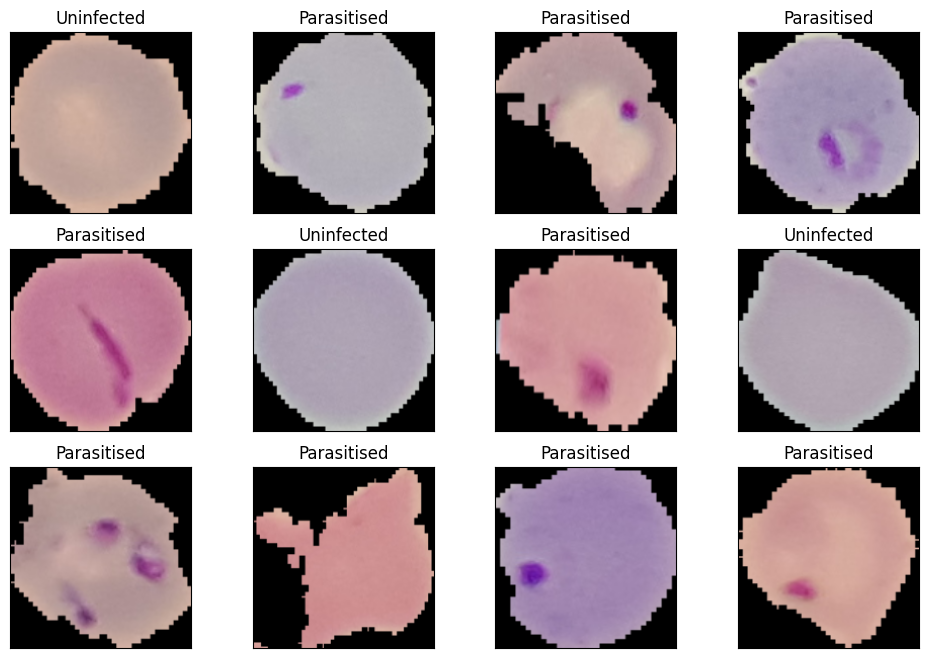

In [31]:
# to extract label as parasitised or un-infected 
def extract_label(label):
    if label==1:
        return 'Uninfected'
    else:
        return 'Parasitised'

# visualizing the samples from test set
plt.figure(figsize=(12,8))
for sample in test_set.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(sample[0][i])
        plt.title(extract_label(sample[1][i].numpy()))
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])

In [32]:
# performing data augmentation to produce samples with slightly varying details and make the model more robust

# defining a Sequential API pipleline to augment data
Augment_Image = tf.keras.Sequential([
    InputLayer(shape=(180,180,3)), # 180x180 pxls and 3 channels of RGB
    RandomContrast(factor=(0.2,0.7), value_range=[0,1]), # randomly picks value between 0.2 & 0.7
    RandomSaturation(factor=(0.2,0.7), value_range=[0,1]), # randomly picks value between 0.2 & 0.7 (0.5=No change, <0.5=Desaturate, >0.5=Saturate)
    RandomFlip(mode='horizontal_and_vertical'), # Sometimes vertical, sometimes horizontal, sometimes both, 
                                               # sometimes none (each chosen independently per image)
    RandomRotation(factor=(-0.2,-0.055), # => rotation angle is randomlypicked between (-0.25*360, -0.055*360) i.e ~(-75,-20) 
                   fill_mode='constant',fill_value=0) # fill the blank pixels after rotation 0=black 255=white
])


In [6]:
# Just for visualizing the augmented images, 
def augment_data(image, label):
    return Augment_Image(image), label

augmented_samples = test_set.take(1).map(augment_data)

2025-09-28 01:02:52.565825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-28 01:02:52.759248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-28 01:02:52.841780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

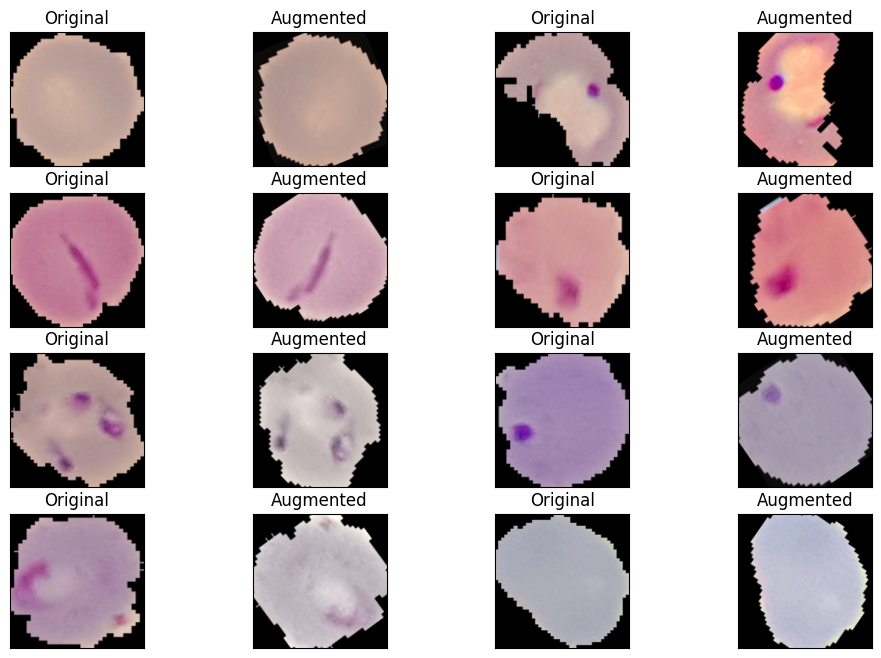

In [7]:
for original, augmented in zip(test_set.take(1),augmented_samples):
    plt.figure(figsize=(12,8))
    for i in range(0,16,2):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(original[0][i])
        plt.title('Original')
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        
        ax = plt.subplot(4,4,i+2)
        plt.imshow(tf.clip_by_value(augmented[0][i], 0.0, 1.0))
        plt.title('Augmented')
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])

In [8]:
# using WandB to visualize the best hyperparameters through fine tuning
!wandb login
os.environ["WANDB_NOTEBOOK_NAME"] = "Malaria_Detection_WorkBook.ipynb" 

wandb: Currently logged in as: r-sumanth (r-sumanth-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
# defining hyperparameters to be initialized into model
sweep_config = {
    'method' : 'random', # / 'grid' / 'bayes'
    'metric' : {
        'name' : 'epoch/val_binary_accuracy', # track validation accuracy 
        'goal' : 'maximize'
    },
    'parameters' : {
        'n_filters_1' : {
            'values' : [6,8,10]
        },
        'n_filters_2' : {
            'values' : [12,16,20]
        },
        'regularize_rate' : {
            'distribution' : 'uniform',  # pick value from unifrom distribution, given the max-min range
            'min' : 0.001,
            'max' : 0.01
        },
        'dropout_rate' : {
            'distribution': 'normal',
            'mu': 0.2,
            'sigma': 0.05  # sample values centered around 0.2, with spread 0.05.
        },
        'n_units_1' : {
            'values' : [108,128,148]
        },
        'n_units_2' : {
            'values' : [48,60,72,84]
        },
        'optimizer': {
            'values' : ['adam', 'sgd']
        },
        'learn_rate' : {
            'distribution' : 'uniform',
            'min' : 0.001,
            'max' : 0.05
        },
        'kernel_size' : {
            'values' : [3,4,5]
        },
        'pool_size' : {
            'values' : [2,3]
        }
    }
}

In [10]:
# logging in confusion matrix, through custom callback
class ConfMtrxLogger(Callback):
    def __init__(self, val_data, y_true, model_path):
        self.val_data = val_data
        self.y_true = y_true
        self.model_path = model_path
        
    def on_train_end(self, logs=None):
        best_model = tf.keras.models.load_model(self.model_path)
        y_pred = tf.squeeze(best_model.predict(self.val_data,verbose=0))
        y_pred = tf.cast((y_pred>0.5), tf.int32).numpy()

        wandb.log({'Confusion Matrix' : wandb.plot.confusion_matrix(y_true=self.y_true, preds=y_pred,
                                                                   class_names=['Parasitized', 'Uninfected'])})

y_true = []
for x,y in cv_set:
    y_true.extend(y.numpy())
y_true = np.array(y_true)

2025-09-28 01:03:49.803588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# defining the LeNet Model for extracting features from image and classifying them
def tune_model(config=None):
    with wandb.init(config=config):
        tf.random.set_seed(58)
        np.random.seed(58)
        random.seed(58)
        
        config = wandb.config
        model = tf.keras.Sequential([
            # augment the images as the first step
            Augment_Image,

            # first convolutional layer
            Conv2D(filters=config.n_filters_1, kernel_size=config.kernel_size, strides=(2,2), padding='valid',activation='relu',
                   kernel_regularizer=L2(config.regularize_rate)), 
            BatchNormalization(),

            # reducing the output of convolutional size by pooling the pixels with max values
            MaxPool2D(config.pool_size, strides=(2,2)),

            # second convolutional layer
            Conv2D(filters=config.n_filters_2, kernel_size=config.kernel_size, strides=(1,1), padding='valid',activation='relu'),
            BatchNormalization(), 

            # drop out to regularize the convolutional layer and increase robustness among the trainable parameters
            SpatialDropout2D(rate=config.dropout_rate), 
            
            MaxPool2D(pool_size=config.pool_size,strides=(2,2)),

            # converting matrix of pixels into arrays 
            Flatten(),

            # features extracted from convolutional layers are fed into series of dense layers to learn classify the samples 
            Dense(units=config.n_units_1,activation='relu'),
            BatchNormalization(),
            Dropout(rate=config.dropout_rate), 
            
            Dense(units=config.n_units_2,activation='relu', kernel_regularizer=L2(config.regularize_rate)),
            BatchNormalization(),
        
            # output layer, giving out the probability of a class the sample may belong to
            Dense(units=1,activation='sigmoid')   
        ])

        # convert optimizer string into objects
        if config.optimizer == 'adam':
            optmzr = Adam
        else:
            optmzr = SGD

        # using BinaryCrossentropy and BinaryAccuracy as this is a binary classifiacation problem
        model.compile(optimizer=optmzr(config.learn_rate), loss=BinaryCrossentropy(), 
                      metrics=[BinaryAccuracy(),Precision(),Recall()])

        # defining callbacks:
        # to stop the training early if there is no improvement in model validation performance for 5 continuous epochs
        early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=4, restore_best_weights=True, verbose=1)
        
        # to automatically reduce the learning weight by half when model validation performance stagnates for 3 continuous runs
        lr_plateau = ReduceLROnPlateau(monitor='val_loss',patience=2, factor=0.5,verbose=1, min_lr=0.001)

        # to save the best model of every run, measured based on model validation accuracy
        model_checkpoint = ModelCheckpoint(filepath=f'ModelCheckpoints/LeNet_Malaria_{wandb.run.name}.keras', 
                                           monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_freq='epoch',mode='max')

        # train the model
        model.fit(train_set, epochs=10, validation_data=cv_set, 
                  callbacks=[WandbMetricsLogger(),lr_plateau,early_stop,model_checkpoint, 
                             ConfMtrxLogger(cv_set,y_true,f'ModelCheckpoints/LeNet_Malaria_{wandb.run.name}.keras')])
        

In [12]:
sweep_id = wandb.sweep(sweep_config, project="Malaria-Detection")
wandb.agent(sweep_id, function=tune_model, count=10)

Create sweep with ID: 1cyn8iov
Sweep URL: https://wandb.ai/r-sumanth-personal/Malaria-Detection/sweeps/1cyn8iov


wandb: Agent Starting Run: xwfimf2x with config:
wandb: 	dropout_rate: 0.19505138129846988
wandb: 	kernel_size: 3
wandb: 	learn_rate: 0.03736984245914479
wandb: 	n_filters_1: 8
wandb: 	n_filters_2: 20
wandb: 	n_units_1: 108
wandb: 	n_units_2: 48
wandb: 	optimizer: sgd
wandb: 	pool_size: 3
wandb: 	regularize_rate: 0.006358414314239354
wandb: Currently logged in as: r-sumanth (r-sumanth-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - binary_accuracy: 0.6221 - loss: 1.0862 - precision: 0.6144 - recall: 0.6736 
Epoch 1: val_binary_accuracy improved from None to 0.49637, saving model to ModelCheckpoints/LeNet_Malaria_warm-sweep-1.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - binary_accuracy: 0.6751 - loss: 0.9893 - precision: 0.6556 - recall: 0.7407 - val_binary_accuracy: 0.4964 - val_loss: 1.4261 - val_precision: 0.4964 - val_recall: 1.0000 - learning_rate: 0.0374
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - binary_accuracy: 0.8008 - loss: 0.7618 - precision: 0.7581 - recall: 0.8894 
Epoch 2: val_binary_accuracy improved from 0.49637 to 0.89840, saving model to ModelCheckpoints/LeNet_Malaria_warm-sweep-1.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - binary_accuracy: 0.8143 - loss: 0.7211 - precision: 0.7685 - recall: 0.9010 - val_binary_accuracy: 0.8984 - val_loss: 0.5295 - val_precision: 0.8452 - val_recall: 0.9737 - learning_rate: 0.0374
E

epoch/binary_accuracy,▁▆▇▇▇███
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▁▁▁▁
epoch/precision,▁▆▇▇▇███
epoch/recall,▁▇▇█████
epoch/val_binary_accuracy,▁██████▇
epoch/val_loss,█▂▁▁▁▁▁▂
epoch/val_precision,▁▇▇▇██▇▆
epoch/val_recall,█▆▇▆▁▅▇▇
epoch/binary_accuracy,0.85462


wandb: Agent Starting Run: mx4g57ie with config:
wandb: 	dropout_rate: 0.18195555385353143
wandb: 	kernel_size: 5
wandb: 	learn_rate: 0.036986271743326325
wandb: 	n_filters_1: 8
wandb: 	n_filters_2: 16
wandb: 	n_units_1: 148
wandb: 	n_units_2: 72
wandb: 	optimizer: sgd
wandb: 	pool_size: 3
wandb: 	regularize_rate: 0.002444451462261103


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - binary_accuracy: 0.5993 - loss: 0.9263 - precision: 0.5960 - recall: 0.6396 
Epoch 1: val_binary_accuracy improved from None to 0.65312, saving model to ModelCheckpoints/LeNet_Malaria_honest-sweep-2.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - binary_accuracy: 0.6470 - loss: 0.8569 - precision: 0.6331 - recall: 0.7031 - val_binary_accuracy: 0.6531 - val_loss: 0.8210 - val_precision: 0.5912 - val_recall: 0.9766 - learning_rate: 0.0370
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - binary_accuracy: 0.7777 - loss: 0.6876 - precision: 0.7407 - recall: 0.8613 
Epoch 2: val_binary_accuracy improved from 0.65312 to 0.87155, saving model to ModelCheckpoints/LeNet_Malaria_honest-sweep-2.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - binary_accuracy: 0.8019 - loss: 0.6548 - precision: 0.7596 - recall: 0.8845 - val_binary_accuracy: 0.8716 - val_loss: 0.5392 - val_precision: 0.7993 - val_recall: 0.9898 - learning_rate: 0.0370

epoch/binary_accuracy,▁▅▇▇▇████
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,████████▁
epoch/loss,█▅▃▂▂▂▂▁▁
epoch/precision,▁▅▆▇▇▇▇██
epoch/recall,▁▆▇██████
epoch/val_binary_accuracy,▁▆▇▇██▅█▆
epoch/val_loss,█▄▃▃▁▁▃▁▃
epoch/val_precision,▁▅▇██▇▇▇█
epoch/val_recall,██▅▄▇█▁▇▃
epoch/binary_accuracy,0.89731


wandb: Agent Starting Run: mbghw6el with config:
wandb: 	dropout_rate: 0.13462507126495282
wandb: 	kernel_size: 3
wandb: 	learn_rate: 0.0012567697200924091
wandb: 	n_filters_1: 8
wandb: 	n_filters_2: 16
wandb: 	n_units_1: 128
wandb: 	n_units_2: 84
wandb: 	optimizer: sgd
wandb: 	pool_size: 2
wandb: 	regularize_rate: 0.009473098044425247


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - binary_accuracy: 0.5289 - loss: 1.8051 - precision: 0.5318 - recall: 0.5561 
Epoch 1: val_binary_accuracy improved from None to 0.51089, saving model to ModelCheckpoints/LeNet_Malaria_chocolate-sweep-3.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - binary_accuracy: 0.5494 - loss: 1.7566 - precision: 0.5469 - recall: 0.5869 - val_binary_accuracy: 0.5109 - val_loss: 1.6724 - val_precision: 0.5040 - val_recall: 0.9284 - learning_rate: 0.0013
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - binary_accuracy: 0.5779 - loss: 1.6900 - precision: 0.5767 - recall: 0.6160 
Epoch 2: val_binary_accuracy improved from 0.51089 to 0.57112, saving model to ModelCheckpoints/LeNet_Malaria_chocolate-sweep-3.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - binary_accuracy: 0.5752 - loss: 1.6798 - precision: 0.5703 - recall: 0.6176 - val_binary_accuracy: 0.5711 - val_loss: 1.6368 - val_precision: 0.5595 - val_recall: 0.6389 - learning_rate: 

epoch/binary_accuracy,▁▃▄▆▆▆▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/precision,▁▃▅▆▆▇▇▇▇█
epoch/recall,▁▃▄▅▅▆▆▆▇█
epoch/val_binary_accuracy,▁▄▅▆▄▆▄▆██
epoch/val_loss,█▇▅▅▅▄▄▃▂▁
epoch/val_precision,▁▃▄▄█▅▆▄▅▆
epoch/val_recall,█▅▅▅▁▄▂▆▆▆
epoch/binary_accuracy,0.63948


wandb: Agent Starting Run: s6q7lb7n with config:
wandb: 	dropout_rate: 0.20520375946490715
wandb: 	kernel_size: 4
wandb: 	learn_rate: 0.01779977528749482
wandb: 	n_filters_1: 6
wandb: 	n_filters_2: 16
wandb: 	n_units_1: 148
wandb: 	n_units_2: 72
wandb: 	optimizer: adam
wandb: 	pool_size: 2
wandb: 	regularize_rate: 0.0028173252718983154


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - binary_accuracy: 0.5917 - loss: 0.8180 - precision: 0.5835 - recall: 0.6679 
Epoch 1: val_binary_accuracy improved from None to 0.49710, saving model to ModelCheckpoints/LeNet_Malaria_upbeat-sweep-4.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - binary_accuracy: 0.6104 - loss: 0.7334 - precision: 0.5970 - recall: 0.6842 - val_binary_accuracy: 0.4971 - val_loss: 0.7398 - val_precision: 0.4967 - val_recall: 1.0000 - learning_rate: 0.0178
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - binary_accuracy: 0.6068 - loss: 0.6905 - precision: 0.5926 - recall: 0.7103 
Epoch 2: val_binary_accuracy did not improve from 0.49710
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - binary_accuracy: 0.6271 - loss: 0.6845 - precision: 0.6010 - recall: 0.7613 - val_binary_accuracy: 0.4971 - val_loss: 0.8570 - val_precision: 0.4967 - val_recall: 1.0000 - learning_rate: 0.0178
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 

epoch/binary_accuracy,▁▁▃▇▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,███████▃▃▁
epoch/loss,█▆▅▁▁▃▃▂▂▁
epoch/precision,▁▁▃▆▇▇▇███
epoch/recall,▁▃▄▇▇▇▇███
epoch/val_binary_accuracy,▁▁▃▅█▇████
epoch/val_loss,▆█▆▅▁▅▂▂▂▂
epoch/val_precision,▁▁▂▄█▆█▇██
epoch/val_recall,███▇▄▇▅▆▁▆
epoch/binary_accuracy,0.87195


wandb: Agent Starting Run: bwo1vsen with config:
wandb: 	dropout_rate: 0.11874092811352747
wandb: 	kernel_size: 3
wandb: 	learn_rate: 0.04707117755387838
wandb: 	n_filters_1: 6
wandb: 	n_filters_2: 12
wandb: 	n_units_1: 108
wandb: 	n_units_2: 60
wandb: 	optimizer: sgd
wandb: 	pool_size: 2
wandb: 	regularize_rate: 0.003150006490093538


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - binary_accuracy: 0.5661 - loss: 0.9476 - precision: 0.5683 - recall: 0.5848 
Epoch 1: val_binary_accuracy improved from None to 0.49565, saving model to ModelCheckpoints/LeNet_Malaria_amber-sweep-5.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - binary_accuracy: 0.5835 - loss: 0.9112 - precision: 0.5816 - recall: 0.6016 - val_binary_accuracy: 0.4956 - val_loss: 0.9095 - val_precision: 0.4960 - val_recall: 0.9985 - learning_rate: 0.0471
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - binary_accuracy: 0.5923 - loss: 0.8670 - precision: 0.5911 - recall: 0.6222 
Epoch 2: val_binary_accuracy improved from 0.49565 to 0.60232, saving model to ModelCheckpoints/LeNet_Malaria_amber-sweep-5.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - binary_accuracy: 0.6340 - loss: 0.8260 - precision: 0.6189 - recall: 0.7020 - val_binary_accuracy: 0.6023 - val_loss: 1.0505 - val_precision: 0.5559 - val_recall: 0.9883 - learning_rate: 0.0471
E

epoch/binary_accuracy,▁▂▆▇▇███
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,██████▁▁
epoch/loss,█▆▄▂▂▂▁▁
epoch/precision,▁▂▅▇▇███
epoch/recall,▁▃▇█████
epoch/val_binary_accuracy,▁▃▇█▇█▇█
epoch/val_loss,▆█▂▁▁▁▁▁
epoch/val_precision,▁▂▆██▇▇▇
epoch/val_recall,█▇▇▅▁▄▄▆
epoch/binary_accuracy,0.8529


wandb: Agent Starting Run: 857hanpx with config:
wandb: 	dropout_rate: 0.17500307203350066
wandb: 	kernel_size: 5
wandb: 	learn_rate: 0.03707603198659093
wandb: 	n_filters_1: 10
wandb: 	n_filters_2: 20
wandb: 	n_units_1: 148
wandb: 	n_units_2: 84
wandb: 	optimizer: adam
wandb: 	pool_size: 2
wandb: 	regularize_rate: 0.0064233937605973086


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - binary_accuracy: 0.5486 - loss: 0.9484 - precision: 0.5482 - recall: 0.6009  
Epoch 1: val_binary_accuracy improved from None to 0.64441, saving model to ModelCheckpoints/LeNet_Malaria_silvery-sweep-6.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - binary_accuracy: 0.5552 - loss: 0.8052 - precision: 0.5505 - recall: 0.6121 - val_binary_accuracy: 0.6444 - val_loss: 0.7324 - val_precision: 0.6720 - val_recall: 0.5541 - learning_rate: 0.0371
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - binary_accuracy: 0.5915 - loss: 0.7145 - precision: 0.5851 - recall: 0.6551 
Epoch 2: val_binary_accuracy did not improve from 0.64441
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - binary_accuracy: 0.5878 - loss: 0.7129 - precision: 0.5805 - recall: 0.6395 - val_binary_accuracy: 0.5036 - val_loss: 0.7255 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0371
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - binary_

epoch/binary_accuracy,▁▃▃▄█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,████▁
epoch/loss,█▄▃▃▁
epoch/precision,▁▃▃▄█
epoch/recall,▁▃▃▃█
epoch/val_binary_accuracy,█▁▁▁▂
epoch/val_loss,▁▁▁▂█
epoch/val_precision,█▁▁▁▇
epoch/val_recall,█▁▁▁▃
epoch/binary_accuracy,0.65667


wandb: Agent Starting Run: q10t16sw with config:
wandb: 	dropout_rate: 0.17774777477348688
wandb: 	kernel_size: 4
wandb: 	learn_rate: 0.016691910309876695
wandb: 	n_filters_1: 6
wandb: 	n_filters_2: 16
wandb: 	n_units_1: 128
wandb: 	n_units_2: 60
wandb: 	optimizer: sgd
wandb: 	pool_size: 3
wandb: 	regularize_rate: 0.008773691180293294


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - binary_accuracy: 0.5447 - loss: 1.4422 - precision: 0.5475 - recall: 0.5643 
Epoch 1: val_binary_accuracy improved from None to 0.50363, saving model to ModelCheckpoints/LeNet_Malaria_fancy-sweep-7.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - binary_accuracy: 0.5614 - loss: 1.3695 - precision: 0.5601 - recall: 0.5811 - val_binary_accuracy: 0.5036 - val_loss: 1.2880 - val_precision: 0.5000 - val_recall: 0.0058 - learning_rate: 0.0167
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - binary_accuracy: 0.6105 - loss: 1.2290 - precision: 0.6118 - recall: 0.6256 
Epoch 2: val_binary_accuracy improved from 0.50363 to 0.68360, saving model to ModelCheckpoints/LeNet_Malaria_fancy-sweep-7.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - binary_accuracy: 0.6181 - loss: 1.1973 - precision: 0.6155 - recall: 0.6338 - val_binary_accuracy: 0.6836 - val_loss: 1.1289 - val_precision: 0.6818 - val_recall: 0.6798 - learning_rate: 0.0167
E

epoch/binary_accuracy,▁▂▃▄▅▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▄▃▂▂▁▁
epoch/precision,▁▂▃▄▅▆▇▇██
epoch/recall,▁▂▃▅▆▇▇███
epoch/val_binary_accuracy,▁▄▅▇▅▆▆▇█▄
epoch/val_loss,█▇▆▄▃▃▃▁▁▅
epoch/val_precision,▁▄▄▅▄▅▅▇▇█
epoch/val_recall,▁▆▇████▇█▄
epoch/binary_accuracy,0.86129


wandb: Agent Starting Run: d92s3pg1 with config:
wandb: 	dropout_rate: 0.20270358487673143
wandb: 	kernel_size: 5
wandb: 	learn_rate: 0.026211188237064673
wandb: 	n_filters_1: 6
wandb: 	n_filters_2: 16
wandb: 	n_units_1: 108
wandb: 	n_units_2: 72
wandb: 	optimizer: adam
wandb: 	pool_size: 3
wandb: 	regularize_rate: 0.00902708191346854


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.5609 - loss: 0.8942 - precision: 0.5590 - recall: 0.6150 
Epoch 1: val_binary_accuracy improved from None to 0.50363, saving model to ModelCheckpoints/LeNet_Malaria_apricot-sweep-8.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - binary_accuracy: 0.5738 - loss: 0.7609 - precision: 0.5676 - recall: 0.6270 - val_binary_accuracy: 0.5036 - val_loss: 1.0690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0262
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - binary_accuracy: 0.6457 - loss: 0.6857 - precision: 0.6310 - recall: 0.7190 
Epoch 2: val_binary_accuracy improved from 0.50363 to 0.76197, saving model to ModelCheckpoints/LeNet_Malaria_apricot-sweep-8.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - binary_accuracy: 0.6688 - loss: 0.6580 - precision: 0.6487 - recall: 0.7396 - val_binary_accuracy: 0.7620 - val_loss: 0.6178 - val_precision: 0.6969 - val_recall: 0.9211 - learning_ra

epoch/binary_accuracy,▁▃▆▆▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,████▃▃▃▃▁▁
epoch/loss,█▆▄▃▂▁▁▁▁▁
epoch/precision,▁▃▆▆▇█████
epoch/recall,▁▄▇▇██████
epoch/val_binary_accuracy,▁▅▂▁▇██▆██
epoch/val_loss,▃▂▃█▁▁▁▂▁▁
epoch/val_precision,▁▆▅▁▇▇█▆██
epoch/val_recall,▁▇█▁██▇███
epoch/binary_accuracy,0.87943


wandb: Agent Starting Run: c1ybwa54 with config:
wandb: 	dropout_rate: 0.2168900622669291
wandb: 	kernel_size: 4
wandb: 	learn_rate: 0.026315642835318665
wandb: 	n_filters_1: 8
wandb: 	n_filters_2: 16
wandb: 	n_units_1: 108
wandb: 	n_units_2: 60
wandb: 	optimizer: adam
wandb: 	pool_size: 2
wandb: 	regularize_rate: 0.00415618816353891


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - binary_accuracy: 0.5522 - loss: 0.8317 - precision: 0.5520 - recall: 0.5987  
Epoch 1: val_binary_accuracy improved from None to 0.50363, saving model to ModelCheckpoints/LeNet_Malaria_light-sweep-9.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - binary_accuracy: 0.5654 - loss: 0.7445 - precision: 0.5602 - recall: 0.6171 - val_binary_accuracy: 0.5036 - val_loss: 0.7080 - val_precision: 0.5000 - val_recall: 0.0175 - learning_rate: 0.0263
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.5994 - loss: 0.6950 - precision: 0.5894 - recall: 0.6899 
Epoch 2: val_binary_accuracy did not improve from 0.50363
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - binary_accuracy: 0.5999 - loss: 0.6954 - precision: 0.5891 - recall: 0.6667 - val_binary_accuracy: 0.4964 - val_loss: 0.7977 - val_precision: 0.4964 - val_recall: 1.0000 - learning_rate: 0.0263
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 

epoch/binary_accuracy,▁▂▃▅▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,███▄▄▄▄▂▂▁
epoch/loss,█▆▅▃▁▁▃▄▅▆
epoch/precision,▁▂▃▆▇▇▇███
epoch/recall,▁▂▂▆▇▇▇███
epoch/val_binary_accuracy,▁▁▁▂▇█▅█▇█
epoch/val_loss,▄▅▅█▁▁▄▂▃▃
epoch/val_precision,▅▅▁▅▇▇█▇▇▇
epoch/val_recall,▁█▁██▇▄█▇█
epoch/binary_accuracy,0.80763


wandb: Agent Starting Run: 6uzw6hlu with config:
wandb: 	dropout_rate: 0.21153660471071248
wandb: 	kernel_size: 3
wandb: 	learn_rate: 0.0034379221900108256
wandb: 	n_filters_1: 8
wandb: 	n_filters_2: 20
wandb: 	n_units_1: 128
wandb: 	n_units_2: 48
wandb: 	optimizer: adam
wandb: 	pool_size: 2
wandb: 	regularize_rate: 0.004094138858707896


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - binary_accuracy: 0.6011 - loss: 0.8665 - precision: 0.5941 - recall: 0.6577 
Epoch 1: val_binary_accuracy improved from None to 0.49637, saving model to ModelCheckpoints/LeNet_Malaria_young-sweep-10.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - binary_accuracy: 0.6581 - loss: 0.7485 - precision: 0.6349 - recall: 0.7476 - val_binary_accuracy: 0.4964 - val_loss: 1.3543 - val_precision: 0.4964 - val_recall: 1.0000 - learning_rate: 0.0034
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - binary_accuracy: 0.8094 - loss: 0.6074 - precision: 0.7667 - recall: 0.8948 
Epoch 2: val_binary_accuracy improved from 0.49637 to 0.89985, saving model to ModelCheckpoints/LeNet_Malaria_young-sweep-10.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - binary_accuracy: 0.8153 - loss: 0.6368 - precision: 0.7727 - recall: 0.8947 - val_binary_accuracy: 0.8999 - val_loss: 0.4902 - val_precision: 0.8413 - val_recall: 0.9839 - learning_rate: 0.0034

epoch/binary_accuracy,▁▆▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,████▃▃▁▁▁▁
epoch/loss,▃▁▂▄▄▄▅▆▇█
epoch/precision,▁▆▇▇██████
epoch/recall,▁▇▇▇▇█████
epoch/val_binary_accuracy,▁██▆███▇█▇
epoch/val_loss,█▁▃▄▃▃▃▄▄▅
epoch/val_precision,▁▆█▅█▇▇▆▇▅
epoch/val_recall,█▇▂▇▁▆▆▆▃▇
epoch/binary_accuracy,0.85607


Now analyzing through the model training logs and details,

From hyperparameter sweep graph, we can observe that runs with <b>higher dropout rate and lower regulairzation rate perform better</b>.

<img src='WandB_Graphs/1.png'>

Observing the top validation accuracy along the epochs,

runs <b>honest-sweep-2, upbeat-sweep-4, young-sweep-10</b> rank at top 3 respectively, with honest-sweep-2 topping 3 out of 5 times when considered overall.

<img src='WandB_Graphs/2.png'>

Considering the training progress of the previously selected runs along the epochs,

runs <b>upbeat-sweep-4, amber-sweep-5, warm-sweep-1</b> have been stable and show almost continuous improvements

<img src='WandB_Graphs/3.png'>

Now studying the confusion matrix and considering the runs with minimum misclassifications of Parasitised samples as Uninfected, as it could risk the life of patient,

runs <b>honest-sweep-2, young-sweep-10, upbeat-sweep-4 & amber-sweep-5</b> stand out with minimum misclassifications of above mentioned.

<img src='WandB_Graphs/4.png'>

Run <b>upbeat-sweep-4</b> is standing out in every aspect. Therefore, going ahead with the configuration of that run.

In [13]:
api = wandb.Api()

# Filter runs by run name
run_name_to_find = 'upbeat-sweep-4' 

runs = api.runs("r-sumanth-personal/Malaria-Detection")

# find the run with the desired name
target_run = None
for run in runs:
    if run.name == run_name_to_find:
        target_run = run
        break

if target_run is None:
    raise ValueError(f"Run named '{run_name_to_find}' not found.")

# Access hyperparameter config
config_params = target_run.config

print(f"Hyperparameters for the run {run_name_to_find} : ")
for key, val in config_params.items():
    print(f"  {key}: {val}")


Hyperparameters for the run upbeat-sweep-4 : 
  n_units_1: 148
  n_units_2: 72
  optimizer: adam
  pool_size: 2
  learn_rate: 0.01779977528749482
  kernel_size: 4
  n_filters_1: 6
  n_filters_2: 16
  dropout_rate: 0.20520375946490715
  regularize_rate: 0.0028173252718983154


In [14]:
# now building the model with according to the best configuration achieved from hyper parameter tuning
def build_model(config):
    tf.random.set_seed(58)
    np.random.seed(58)
    random.seed(58)
    
    model = tf.keras.Sequential([
        Augment_Image,
        
        Conv2D(filters=config['n_filters_1'], kernel_size=config['kernel_size'], strides=(2,2), padding='valid',activation='relu',
               kernel_regularizer=L2(config['regularize_rate'])), 
        BatchNormalization(),

        MaxPool2D(config['pool_size'], strides=(2,2)),

        Conv2D(filters=config['n_filters_2'], kernel_size=config['kernel_size'], strides=(1,1), padding='valid',activation='relu'),
        BatchNormalization(), 

        SpatialDropout2D(rate=config['dropout_rate']), 
        
        MaxPool2D(pool_size=config['pool_size'],strides=(2,2)),

        Flatten(),

        Dense(units=config['n_units_1'],activation='relu'),
        BatchNormalization(),
        Dropout(rate=config['dropout_rate']), 
        
        Dense(units=config['n_units_2'],activation='relu', kernel_regularizer=L2(config['regularize_rate'])),
        BatchNormalization(),
    
        Dense(units=1,activation='sigmoid')   
    ])

    if config['optimizer'] == 'adam':
        optmzr = Adam
    else:
        optmzr = SGD

    model.compile(optimizer=optmzr(config['learn_rate']), loss=BinaryCrossentropy(), 
                  metrics=[BinaryAccuracy(),Precision(),Recall()])

    return model

In [15]:
model = build_model(config_params)

In [16]:
with wandb.init(project='Malaria-Detection', name='best-params',save_code=True) as run:
    early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True, verbose=1)
            
    lr_plateau = ReduceLROnPlateau(monitor='val_loss',patience=3, factor=0.5,verbose=1, min_lr=0.001)
    
    model_checkpoint = ModelCheckpoint(filepath=f'ModelCheckpoints/LeNet_Malaria_{wandb.run.name}.keras', 
                                       monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_freq='epoch',mode='max')

    history = model.fit(train_set, validation_data=cv_set, epochs=25,
                        callbacks=[WandbMetricsLogger(),early_stop,lr_plateau,model_checkpoint,
                                   ConfMtrxLogger(cv_set,y_true,f'ModelCheckpoints/LeNet_Malaria_{wandb.run.name}.keras')])

Epoch 1/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - binary_accuracy: 0.5674 - loss: 0.8269 - precision: 0.5672 - recall: 0.6048 
Epoch 1: val_binary_accuracy improved from None to 0.50363, saving model to ModelCheckpoints/LeNet_Malaria_best-params.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 67s 186ms/step - binary_accuracy: 0.5703 - loss: 0.7431 - precision: 0.5674 - recall: 0.6000 - val_binary_accuracy: 0.5036 - val_loss: 0.7521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0178
Epoch 2/25
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 0.5941 - loss: 0.6889 - precision: 0.5957 - recall: 0.6141 
Epoch 2: val_binary_accuracy improved from 0.50363 to 0.50871, saving model to ModelCheckpoints/LeNet_Malaria_best-params.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - binary_accuracy: 0.5831 - loss: 0.6929 - precision: 0.5799 - recall: 0.6090 - val_binary_accuracy: 0.5087 - val_loss: 0.6983 - val_precision: 1.0000 - val_recall: 0.0102 - learning_rate: 0.

epoch/binary_accuracy,▁▁▂▁▆▇████████████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,█████████▄▄▄▄▂▂▂▁▁
epoch/loss,█▇▇▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁
epoch/precision,▁▁▂▁▅▇▇▇██████████
epoch/recall,▁▁▂▂▇█████████████
epoch/val_binary_accuracy,▁▁▁▃▇█▆████▇██████
epoch/val_loss,█▇██▃▁▃▂▂▁▂▃▁▂▁▁▁▁
epoch/val_precision,▁█▄▅▆▇▆▇▇▇▇▇▇█▇▇▇▇
epoch/val_recall,▁▁█▇█████████▇████
epoch/binary_accuracy,0.90293


In [24]:
# evaluating model on test dataset
evaluation = model.evaluate(test_set)

for metric,value in zip(['Loss','Accuracy','Precision','Recall'],evaluation):
    print(metric,' : ',round(value,4))
    

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.9291 - loss: 0.2491 - precision: 0.9023 - recall: 0.9609
Loss  :  0.2491
Accuracy  :  0.9291
Precision  :  0.9023
Recall  :  0.9609


Model is performing well on both cross validation and test dataset, with around 93% accuracy.

2025-09-28 13:24:37.610274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


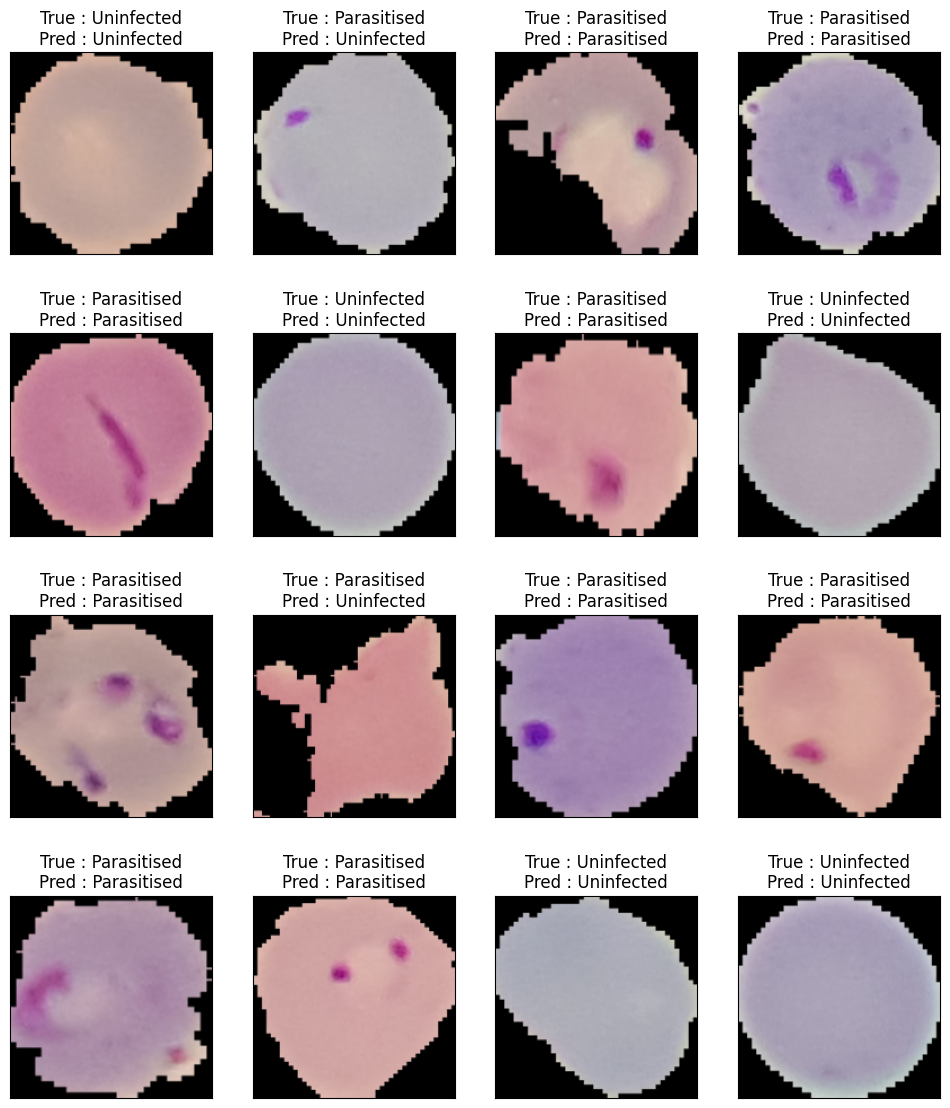

In [37]:
# plotting the Actual vs Predicted of the test set
        
for image, label in test_set.take(1):
    plt.figure(figsize=(12,14))
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i])
        plt.title("True : "+extract_label(label[i].numpy())+"\nPred : "+extract_label(tf.round(model.predict(image,verbose=0)[i])))
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])

We can see a couple of misclassification out of the visualized.